In [16]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation,MaxPooling2D,Dropout
from keras.layers.core import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler,CSVLogger,LambdaCallback,TensorBoard
from keras import regularizers
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
import seaborn as sns
import math
import os

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
%matplotlib inline

In [17]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
train_path = '/kaggle/input/mydataset/archive1/Training'
valid_path = '/kaggle/input/mydataset/archive1/Testing'

train_gen = ImageDataGenerator(
    rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False
)
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True,
  )

train_batches = train_gen.flow_from_directory(directory=train_path, target_size=(224,224),
   # classes=['Glioma', 'Meningioma', 'Pituitary tumor'], 
                                              batch_size=10, shuffle=False)

valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_path, target_size=(224,224), 
    #classes=['Glioma', 'Meningioma', 'Pituitary tumor'],
                                                                       batch_size=10, shuffle=False)



Found 4117 images belonging to 3 classes.
Found 906 images belonging to 3 classes.


In [18]:
IMAGE_SIZE = [224, 224]

In [19]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False #,   pooling='avg'
             )

In [20]:

from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras import layers

In [21]:
# don't train existing weights
for layer in vgg16.layers:
   layer.trainable = False

In [22]:
x = vgg16.output
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
#x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=vgg16.inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
model5_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 6, verbose = 1)
model5_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model5_mcp = ModelCheckpoint(filepath = 'model5_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

In [25]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=10e-5),metrics=['categorical_accuracy'])

In [26]:
history = model.fit_generator(generator=train_batches,
                                    #steps_per_epoch=len(train_batches),
                                 validation_data=valid_batches, 
                                 #validation_steps=len(valid_batches), 
                                    epochs=100,  callbacks=[model5_es, model5_rlr, model5_mcp])

Epoch 1/100
412/412 [==============================] - 30s 70ms/step - loss: 0.8456 - categorical_accuracy: 0.6502 - val_loss: 0.5391 - val_categorical_accuracy: 0.7671

Epoch 00001: val_categorical_accuracy improved from -inf to 0.76711, saving model to model5_weights.h5
Epoch 2/100
412/412 [==============================] - 29s 71ms/step - loss: 0.5015 - categorical_accuracy: 0.7977 - val_loss: 0.4620 - val_categorical_accuracy: 0.8113

Epoch 00002: val_categorical_accuracy improved from 0.76711 to 0.81126, saving model to model5_weights.h5
Epoch 3/100
412/412 [==============================] - 29s 71ms/step - loss: 0.4208 - categorical_accuracy: 0.8244 - val_loss: 0.3743 - val_categorical_accuracy: 0.8466

Epoch 00003: val_categorical_accuracy improved from 0.81126 to 0.84658, saving model to model5_weights.h5
Epoch 4/100
412/412 [==============================] - 29s 71ms/step - loss: 0.3321 - categorical_accuracy: 0.8732 - val_loss: 0.3022 - val_categorical_accuracy: 0.8764

Epoch

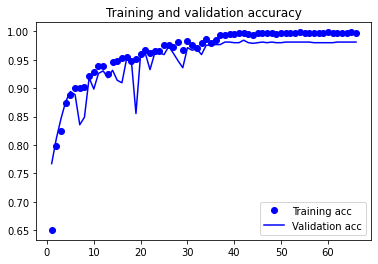

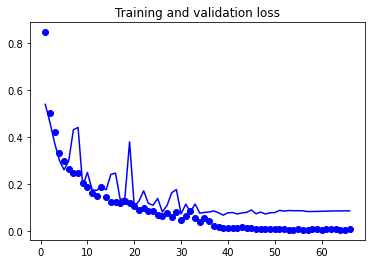

In [28]:
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.savefig('accuracy.png')
plt.show()

In [29]:
from tensorflow.keras.models import load_model

model.save('model_(1).h5')

In [31]:
test_model = load_model('model_(1).h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


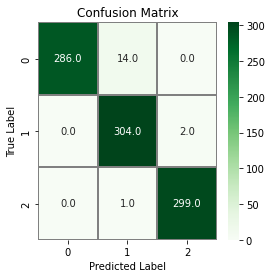

<Figure size 432x288 with 0 Axes>

In [32]:
predictions_1 = test_model.predict_generator(generator=valid_batches, 
                                             steps=len(valid_batches), verbose=0
                                             )

pred_label = np.argmax(predictions_1,axis=1)
classes = np.argmax(predictions_1, axis=1)
cm = confusion_matrix(valid_batches.labels,pred_label)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confusion_matrix.png')

In [35]:
predictions = test_model.predict_generator(valid_batches, steps=1, verbose=0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [36]:
rounded_prediction = np.argmax(predictions, axis=-1)
for i in rounded_prediction:
    print(i)

0
0
0
0
0
0
0
0
0
0


In [37]:
true_labels = valid_batches .classes
predictions = model.predict_generator(valid_batches )


In [38]:
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

In [39]:
import sklearn

In [40]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [41]:
cm

array([[286,  14,   0],
       [  0, 304,   2],
       [  0,   1, 299]])

In [42]:
cm = confusion_matrix(y_true=valid_batches.labels, y_pred=pred_label)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(classification_report(y_true=valid_batches.labels, y_pred=pred_label))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       300
           1       0.95      0.99      0.97       306
           2       0.99      1.00      1.00       300

    accuracy                           0.98       906
   macro avg       0.98      0.98      0.98       906
weighted avg       0.98      0.98      0.98       906



Confusion matrix, without normalization
[[286  14   0]
 [  0 304   2]
 [  0   1 299]]


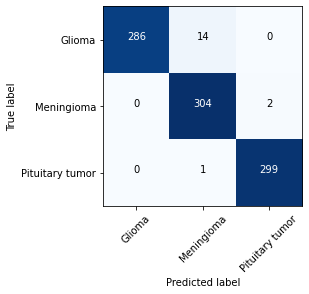

In [43]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['Glioma','Meningioma', 'Pituitary tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [45]:
testY = valid_batches.classes

In [46]:
class_to_label_map = {2 : 'Pituitary tumor', 1 : 'Meningioma', 0 : 'Glioma'}

In [47]:
classes = dict((v, k) for k, v in valid_batches.class_indices.items())
num_classes = len(classes)
num_samples = len(valid_batches)

In [50]:
test_model = load_model('/kaggle/working/model5_weights.h5')

In [51]:
test_imgs, test_labels = next(valid_batches)

In [52]:
rounded_labels = np.argmax(test_labels# , axis=-1
                           )

In [54]:
predictions = test_model.predict_generator( valid_batches, verbose=0)

In [55]:
predictions

array([[1.0000000e+00, 2.9965352e-10, 2.6962538e-11],
       [1.0000000e+00, 4.4204249e-09, 4.5590026e-10],
       [9.9999988e-01, 1.0953231e-07, 2.9069486e-08],
       ...,
       [4.3135207e-10, 1.0406388e-08, 1.0000000e+00],
       [2.6473181e-11, 1.8609945e-11, 1.0000000e+00],
       [1.0240493e-13, 1.3016255e-09, 1.0000000e+00]], dtype=float32)

In [57]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [58]:
for i in rounded_prediction:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [59]:
cm = confusion_matrix(y_true=true_labels, y_pred=rounded_prediction)

In [62]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[290  10   0]
 [  1 303   2]
 [  0   1 299]]


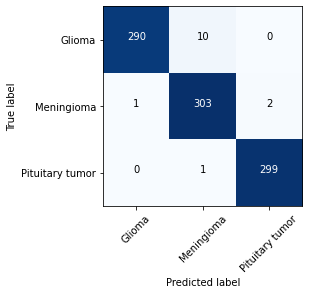

In [63]:
cm_plot_labels = ['Glioma','Meningioma', 'Pituitary tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [64]:
y_score = model.predict_generator(valid_batches)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [65]:
from keras.utils.np_utils import to_categorical  

In [66]:
y_true_categorical = valid_batches.classes
y_true = (to_categorical(y_true_categorical, num_classes = num_classes))


In [67]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


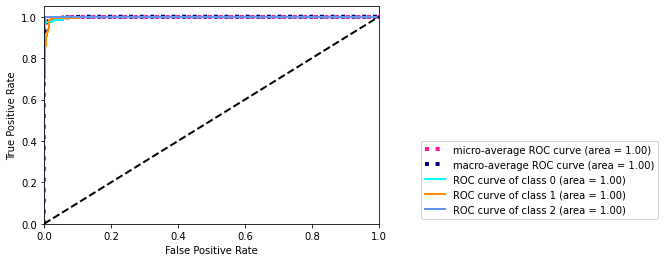

In [68]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.title('Receiver operating characteristic (ROC) to Multi-Class Validation Set (' + model_name + ')')
plt.legend(bbox_to_anchor=(1.85,0), loc="lower right")
#plt.savefig(model_path + '0_results/Model' + '_' + model_name + '_' + str(epochs) + '_epochs_ROC_Validation.png', dpi=600, bbox_inches="tight")
plt.show()


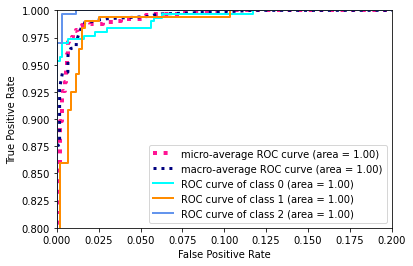

In [69]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()